Так мы можем узнать, сколько времени занимает выполнение всего блокнота.<br/> 
Узнаем время в начале выполнения, узнаем время в конце, вычитаем одно из другого. 

In [1]:
import datetime
start = datetime.datetime.now()

Самые удобные способы загрузить дайкомы в один массив:
* Сконвертировать их в .nii с помощью чего-нибудь типа dcm2niix. 
* Использовать ImageSeriesReader из библиотеки SimpleITK. В этот раз будем делать именно так. 

In [2]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

Что происходит в следующих ячейках: 
1. Создаем объект ImageSeriesReader. 
2. Делаем список путей к файлам в диком-папке. Можно сделать и генератор c os.listdir(), но метод GetGDCMSeriesFileNames чуть проще. 
3. Скармливаем созданному в первом шаге ридеру созданный во втором шаге список. 
4. Просим ридер выполнить чтение. 

In [3]:
reader = sitk.ImageSeriesReader() 

In [4]:
dicom_names = reader.GetGDCMSeriesFileNames('29_07_2020_10_25_38')
dicom_names[:5] # Тут ничего не отрезается, а просто показываются первые пять объектов в списке

('29_07_2020_10_25_38/IMG-0001-00001.dcm',
 '29_07_2020_10_25_38/IMG-0001-00002.dcm',
 '29_07_2020_10_25_38/IMG-0001-00003.dcm',
 '29_07_2020_10_25_38/IMG-0001-00004.dcm',
 '29_07_2020_10_25_38/IMG-0001-00005.dcm')

In [5]:
reader.SetFileNames(dicom_names)

In [6]:
image = reader.Execute()
type(image)

SimpleITK.SimpleITK.Image

Метод GetArrayFromImage превращает объект типа `SimpleITK.SimpleITK.Image`, который мы только что получили, в стандартный numpy-массив. 

In [7]:
perf_array = sitk.GetArrayFromImage(image)
type(perf_array)

numpy.ndarray

In [8]:
perf_array.shape

(712, 512, 512)

Мы заранее знаем, что в исследовании 89 объемов по 8 срезов. Надо сделать решейп. 

In [9]:
perf_array = perf_array.reshape(89, 8, 512, 512)

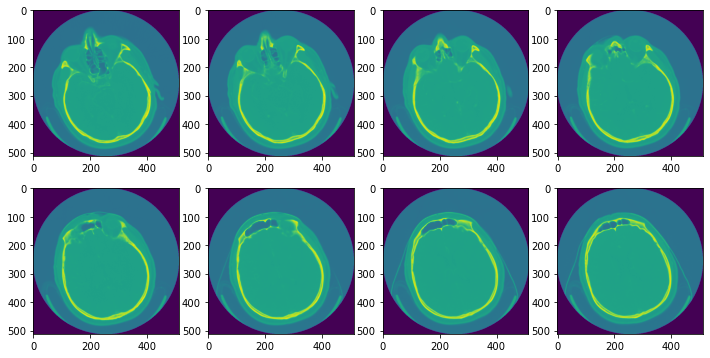

In [10]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(perf_array[23, i, :, :])
plt.show()

Ширина окна CLUT настраивается параметрами vmin и vmax, подаваемыми на вход функции `imshow`. 

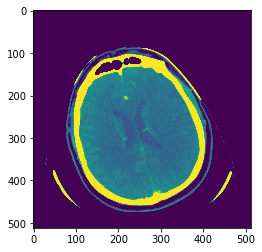

In [11]:
plt.imshow(perf_array[23, i, :, :], vmin=-50, vmax=200)

Можно сразу занулить значения костей и воздуха с помощью маски. 

In [12]:
perf_array_z = perf_array.copy() # Если сделать просто perf_array_z = perf_array, то при изменении 
                                 # perf_array_z будет меняться и perf_array. Массивы так работают. 

In [13]:
perf_array_z[perf_array>300] = 0 # perf_array>300 возвращает массив, где каждому вокселу соответствует 
                                 # значение True или False. Мы берем только тру-вокселы и зануляем их. 
perf_array_z[perf_array<-50] = 0 

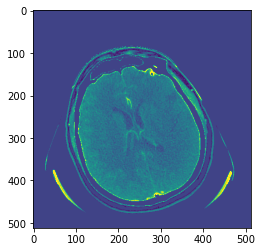

In [14]:
plt.imshow(perf_array_z[23, 6, :, :], vmin=-50, vmax=200)

Размытие с помощью гауссовского фильтра. 

In [15]:
from scipy.ndimage import gaussian_filter

Вот что приятно: можно задать значение размытия отдельно для каждой оси (у нас их четыре: временная, потом ось z, по которой идут срезы, и собственно оси x и y). Мы хотим размыть только сами срезы. 

In [16]:
blurred = gaussian_filter(perf_array_z, sigma=[0,0,3,3])

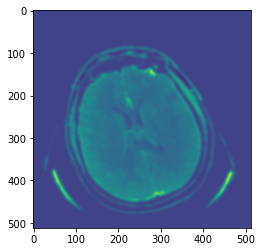

In [17]:
plt.imshow(blurred[23, 6, :, :], vmin=-50, vmax=200)

Следующая ячейка открывает отдельное окно просмотрщика, в котором мы выбираем воксель из артерии. 

Воксел с координатами [6,205,219] - это артерия. <br/>
Воксел с координатами [5,278,125] - это не артерия. 

Отрисуем графики и заблюренных и незаблюренных объемов. 

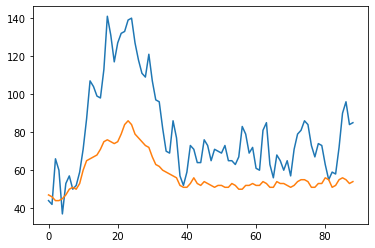

In [18]:
plt.plot(perf_array[:,6,205,219])
plt.plot(blurred[:,6,205,219])

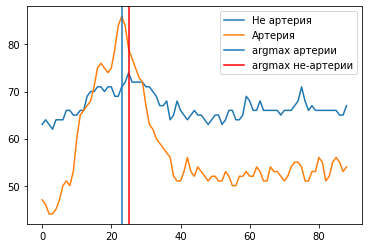

In [19]:
plt.plot(blurred[:,5,278,125], label='Не артерия')
plt.plot(blurred[:,6,205,219], label='Артерия')
plt.axvline(np.argmax(blurred[:,6,205,219]), label='argmax артерии')
plt.axvline(np.argmax(blurred[:,5,278,125]), label='argmax не-артерии', c='r')
plt.legend()

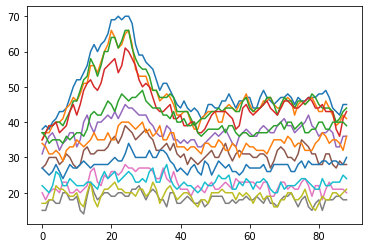

In [20]:
for i in range(222,260,3):
    plt.plot(blurred[:,6,i,i])
plt.show()

Давайте теперь узнаем, в какой момент времени плотность в каждом вокселе была максимальной. Функция argmax из библиотеки numpy хорошо подходит для этого. 

In [21]:
argmax_array = np.argmax(blurred, axis=0)

In [22]:
argmax_array.shape

(8, 512, 512)

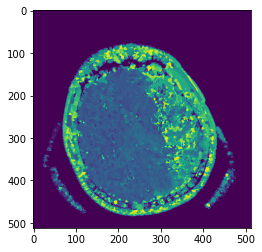

In [23]:
plt.imshow(argmax_array[6, :, :]) #шестой срез довольно иллюстративный

Пик контрастирования в бассейне левой средней мозговой артерии значительно позже, чем в симметричном бассейне справа. Это потому что слева - острейший инфаркт. 

После того, как мы реализовали Time to Peak, мы пишем суррогат для Cerebral Blood Flow. 

[<img src="https://prod-images-static.radiopaedia.org/images/51397389/b3ba498548c67b7e963d6e1816841e_big_gallery.jpeg" width="400">](https://radiopaedia.org/articles/ct-perfusion-in-ischaemic-stroke)

Очевидно, нужно найти максимальный угол касательной для графика изменения плотности. 

Чтобы график был более плавным, добавим гауссовское сглаживание по временной оси. 

In [24]:
blurred = gaussian_filter(perf_array_z, sigma=[3,0,3,3])

Для оценки производной воспользуемся функцией gradient из библиотеки numpy. 

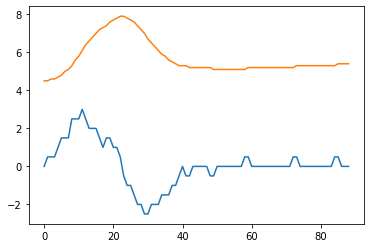

In [25]:
gradient_artery = np.gradient(blurred[:,6,205,219])
plt.plot(gradient_artery)
plt.plot(blurred[:,6,205,219]/10)

На вид все верно. Где максимальная скорость нарастания, там максимальное значение градиента.

In [26]:
gradient = np.gradient(blurred, axis=0)

Делаем массив с повоксельной оценкой градиента. 

In [27]:
max_grad = np.max(gradient, axis=0)

In [28]:
max_grad.shape

(8, 512, 512)

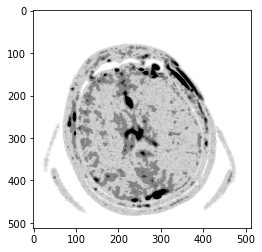

In [29]:
plt.imshow(max_grad[6], vmin=0, vmax=1.8, cmap='Greys')

На вид - слева, где задержка контрастного усиления, кора действительно дифференцируется хуже. 

In [30]:
end = datetime.datetime.now()
end-start

datetime.timedelta(seconds=21, microseconds=456639)